In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [489]:
data_dir = Path("wrapperocr/")
#data_dir = Path("./captcha_images_v2/")

In [511]:
#Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split("_")[0] for img in images]
#belowis doc
#labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 1

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  864
Number of labels found:  864
Number of unique characters:  19
Characters present:  ['&', 'a', 'c', 'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'q', 'r', 's', 't', 'u', 'y']


In [512]:
labels

['cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'do

In [513]:
864/16

54.0

In [514]:
max_length

8

In [515]:
288/16

18.0

In [516]:
1040/16

65.0

In [517]:
#Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    print(img.shape)
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    print(img.shape)
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [518]:
len(y_train)/16

48.5625

In [519]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

print(train_dataset)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


(50, 200, 1)
(200, 50, 1)
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
(50, 200, 1)
(200, 50, 1)


In [520]:
validation_dataset

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [521]:
train_dataset

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [522]:
16, 200, 50, 1

(16, 200, 50, 1)

In [523]:
for batch in train_dataset.take(1):
    #print(batch)
    print(batch["image"].shape)
    print(batch["label"].shape)

(1, 200, 50, 1)
(1, 7)


(1, 200, 50, 1)
(1, 7)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

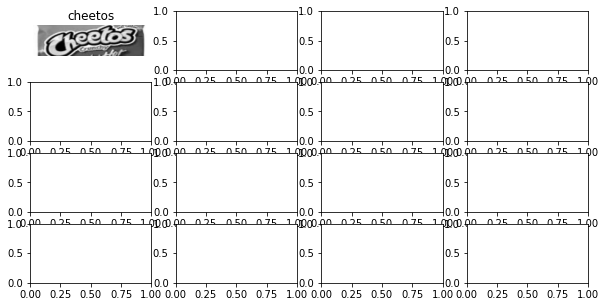

In [524]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print(batch["image"].shape)
    print(batch["label"].shape)
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [560]:
!pip3 install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-macosx_10_16_x86_64.whl (53.9 MB)


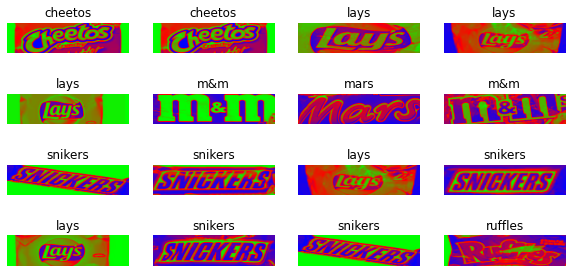

In [562]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
'''
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print(batch["image"].shape)
    print(batch["label"].shape)
'''
for i in range(16):
    for batch in train_dataset.take(i):
        images = batch["image"]
        labels = batch["label"]
        images= (images* 255).numpy().reshape(200, 50, 1)
        label = tf.strings.reduce_join(num_to_char(labels)).numpy().decode("utf-8")
        #print(images.shape)
        #images =cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    ax[i // 4, i % 4].imshow(images[:, :, 0].T,cmap='brg')
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
    

In [525]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [551]:
epochs = 5
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/5
777/777 [==============================] - 76s 98ms/step - loss: 1.1470 - val_loss: 0.5132
Epoch 2/5
777/777 [==============================] - 63s 81ms/step - loss: 0.3202 - val_loss: 0.1756
Epoch 3/5
777/777 [==============================] - 72s 92ms/step - loss: 0.1551 - val_loss: 0.0752
Epoch 4/5
777/777 [==============================] - 71s 91ms/step - loss: 0.0924 - val_loss: 0.0482
Epoch 5/5
777/777 [==============================] - 93s 120ms/step - loss: 0.0484 - val_loss: 0.0105


In [563]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

In [564]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

0
1
tf.Tensor([[ 3  7  5  5 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 50ms/step
['cheetos[UNK]']
cheetos
2
tf.Tensor([[ 3  7  5  5 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 56ms/step
['cheetos[UNK]']
cheetos
tf.Tensor([[ 6 15  8 17 13 16]], shape=(1, 6), dtype=int64)
1/1 [==============================] - 0s 42ms/step
['fritos[UNK][UNK]']
fritos
3
tf.Tensor([[ 3  7  5  5 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 52ms/step
['cheetos[UNK]']
cheetos
tf.Tensor([[ 6 15  8 17 13 16]], shape=(1, 6), dtype=int64)
1/1 [==============================] - 0s 58ms/step
['fritos[UNK][UNK]']
fritos
tf.Tensor([[15 18  6  6 10  5 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 48ms/step
['ruffles[UNK]']
ruffles
4
tf.Tensor([[ 3  7  5  5 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 50ms/step
['cheetos[UNK]']
cheetos
tf.Tensor(

1/1 [==============================] - 0s 48ms/step
['lays[UNK][UNK][UNK][UNK]']
lays
tf.Tensor([[10  2 19 16]], shape=(1, 4), dtype=int64)
1/1 [==============================] - 0s 45ms/step
['lays[UNK][UNK][UNK][UNK]']
lays
tf.Tensor([[ 3  7  5  5 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 51ms/step
['cheetos[UNK]']
cheetos
tf.Tensor([[ 6 15  8 17 13 16]], shape=(1, 6), dtype=int64)
1/1 [==============================] - 0s 54ms/step
['fritos[UNK][UNK]']
fritos
tf.Tensor([[15 18  6  6 10  5 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 44ms/step
['ruffles[UNK]']
ruffles
tf.Tensor([[11  1 11]], shape=(1, 3), dtype=int64)
1/1 [==============================] - 0s 59ms/step
['m&m[UNK][UNK][UNK][UNK][UNK]']
m&m
tf.Tensor([[10  2 19 16]], shape=(1, 4), dtype=int64)
1/1 [==============================] - 0s 52ms/step
['lays[UNK][UNK][UNK][UNK]']
lays
tf.Tensor([[ 3  7  5  5 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [======

['tostitos']
tostitos
tf.Tensor([[16 12  8  9  5 15 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 47ms/step
['snikers[UNK]']
snikers
tf.Tensor([[15 18  6  6 10  5 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 57ms/step
['ruffles[UNK]']
ruffles
tf.Tensor([[ 4 13 15  8 17 13 16]], shape=(1, 7), dtype=int64)
1/1 [==============================] - 0s 62ms/step
['doritos[UNK]']
doritos


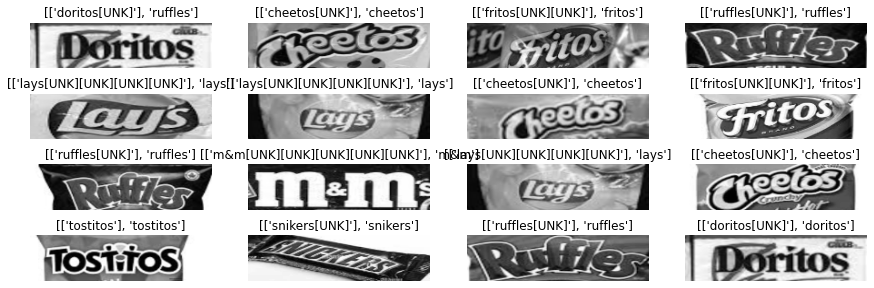

In [652]:
 _, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    print(i)
    for batch in validation_dataset.take(i):
        batch_images = batch["image"]
        batch_labels = batch["label"]
        print(batch_labels)
        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)
        print(pred_texts)
        label = tf.strings.reduce_join(num_to_char(batch_labels)).numpy().decode("utf-8")
        print(label)
    img_1=batch_images.numpy().reshape(200, 50, 1)   
    ax[i // 4, i % 4].imshow(img_1[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title([pred_texts,label])
    ax[i // 4, i % 4].axis("off")
plt.show()

In [625]:
batch_images.numpy().shape

(1, 200, 50, 1)

In [632]:
img_1=batch_images.numpy().reshape(200, 50, 1)

In [642]:
img_1.shape

(200, 50, 1)

In [643]:
img_1[:, :, 0].T

array([[0.3866667 , 0.34098825, 0.32313725, ..., 0.3801569 , 0.37854123,
        0.37568632],
       [0.25254905, 0.26610982, 0.2947843 , ..., 0.34349024, 0.33861178,
        0.3364706 ],
       [0.21176472, 0.2902745 , 0.33803922, ..., 0.4554902 , 0.45847064,
        0.454902  ],
       ...,
       [0.8000001 , 0.8071373 , 0.8178432 , ..., 0.8590195 , 0.88552934,
        0.9176471 ],
       [0.8109805 , 0.8202589 , 0.8265099 , ..., 0.8590195 , 0.88552934,
        0.9176471 ],
       [0.81568635, 0.8228236 , 0.82419616, ..., 0.8563528 , 0.8858117 ,
        0.92078435]], dtype=float32)

In [660]:
img_1*120

array([[[ 46.4     ],
        [ 30.305885],
        [ 25.411766],
        ...,
        [ 96.00001 ],
        [ 97.31766 ],
        [ 97.88236 ]],

       [[ 40.91859 ],
        [ 31.933178],
        [ 34.83294 ],
        ...,
        [ 96.856476],
        [ 98.43107 ],
        [ 98.73883 ]],

       [[ 38.77647 ],
        [ 35.374115],
        [ 40.564705],
        ...,
        [ 98.14118 ],
        [ 99.18119 ],
        [ 98.90354 ]],

       ...,

       [[ 45.618828],
        [ 41.21883 ],
        [ 54.658825],
        ...,
        [103.082344],
        [103.082344],
        [102.76234 ]],

       [[ 45.42495 ],
        [ 40.633415],
        [ 55.016476],
        ...,
        [106.26352 ],
        [106.26352 ],
        [106.2974  ]],

       [[ 45.08236 ],
        [ 40.376472],
        [ 54.588238],
        ...,
        [110.11765 ],
        [110.11765 ],
        [110.494125]]], dtype=float32)

In [662]:
img_f=img_1*120

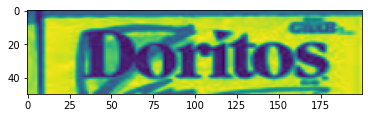

In [663]:
plt.imshow(img_f[:, :, 0].T)
plt.show()

In [655]:
preds.shape

(1, 50, 21)

In [656]:
decode_batch_predictions(preds)

['doritos[UNK]']

In [653]:
pred_texts

['doritos[UNK]']

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  2937k      0  0:00:03  0:00:03 --:--:-- 4032k


In [88]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/")

In [280]:
# Path to the data directory
data_dir2 = Path("./wrapper_ocr/")

In [291]:
# Get list of all the images
images = sorted(list(map(str, list(data_dir2.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split("_")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 4

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  144
Number of labels found:  144
Number of unique characters:  19
Characters present:  ['&', 'a', 'c', 'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'q', 'r', 's', 't', 'u', 'y']


In [292]:
labels

['cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'doritos',
 'fritos',
 'fritos',
 'fritos',
 'fritos',
 'fritos',
 'fritos',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'quest',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffl

In [293]:
images

['wrapper_ocr/cheetos_09876 copy 2.png',
 'wrapper_ocr/cheetos_09876 copy.png',
 'wrapper_ocr/cheetos_09876.png',
 'wrapper_ocr/cheetos_34 copy 2.png',
 'wrapper_ocr/cheetos_34 copy.png',
 'wrapper_ocr/cheetos_34.png',
 'wrapper_ocr/cheetos_566 copy 2.png',
 'wrapper_ocr/cheetos_566 copy.png',
 'wrapper_ocr/cheetos_566.png',
 'wrapper_ocr/cheetos_67 copy 2.png',
 'wrapper_ocr/cheetos_67 copy.png',
 'wrapper_ocr/cheetos_67.png',
 'wrapper_ocr/doritos_1 copy 2.png',
 'wrapper_ocr/doritos_1 copy.png',
 'wrapper_ocr/doritos_1.png',
 'wrapper_ocr/doritos_34 copy 2.png',
 'wrapper_ocr/doritos_34 copy.png',
 'wrapper_ocr/doritos_34.png',
 'wrapper_ocr/doritos_56 copy 2.png',
 'wrapper_ocr/doritos_56 copy.png',
 'wrapper_ocr/doritos_56.png',
 'wrapper_ocr/fritos_1 copy 2.png',
 'wrapper_ocr/fritos_1 copy.png',
 'wrapper_ocr/fritos_1.png',
 'wrapper_ocr/fritos_23 copy 2.png',
 'wrapper_ocr/fritos_23 copy.png',
 'wrapper_ocr/fritos_23.png',
 'wrapper_ocr/lays_1 copy 2.png',
 'wrapper_ocr/lays_1 

In [294]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.6, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [295]:
encode_single_sample("wrapper_ocr/lays_6787 copy 2.png",'cheetos')

{'image': <tf.Tensor: shape=(200, 50, 1), dtype=float32, numpy=
 array([[[0.75186276],
         [0.775542  ],
         [0.77647066],
         ...,
         [0.4991019 ],
         [0.58010316],
         [0.64489967]],
 
        [[0.7675028 ],
         [0.7723075 ],
         [0.771706  ],
         ...,
         [0.484596  ],
         [0.59021527],
         [0.6611177 ]],
 
        [[0.7699177 ],
         [0.75717264],
         [0.7572942 ],
         ...,
         [0.52831364],
         [0.63290554],
         [0.6886667 ]],
 
        ...,
 
        [[0.4156863 ],
         [0.4411726 ],
         [0.44680396],
         ...,
         [0.68823516],
         [0.72562313],
         [0.7934666 ]],
 
        [[0.7633537 ],
         [0.7729466 ],
         [0.7757419 ],
         ...,
         [0.8866004 ],
         [0.8982261 ],
         [0.9196991 ]],
 
        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.     

In [296]:
x_train

array(['wrapper_ocr/ruffles_87656.png',
       'wrapper_ocr/snikers_6543 copy 2.png',
       'wrapper_ocr/lays_123 copy 2.png', 'wrapper_ocr/snikers_0987.png',
       'wrapper_ocr/ruffles_876.png', 'wrapper_ocr/lays_1.png',
       'wrapper_ocr/doritos_34.png', 'wrapper_ocr/quest_1  copy.png',
       'wrapper_ocr/doritos_1.png', 'wrapper_ocr/lays_233.png',
       'wrapper_ocr/lays_89.png', 'wrapper_ocr/ruffles_78.png',
       'wrapper_ocr/quest_234 copy.png', 'wrapper_ocr/lays_23 copy.png',
       'wrapper_ocr/cheetos_09876.png', 'wrapper_ocr/mars_987.png',
       'wrapper_ocr/lays_1 copy.png', 'wrapper_ocr/ruffles_78 copy.png',
       'wrapper_ocr/cheetos_67.png',
       'wrapper_ocr/ruffles_0987 copy 2.png',
       'wrapper_ocr/snikers_8765.png',
       'wrapper_ocr/ruffles_78 copy 2.png', 'wrapper_ocr/m&m_0987.png',
       'wrapper_ocr/lays_123.png', 'wrapper_ocr/fritos_23 copy.png',
       'wrapper_ocr/lays_233 copy.png', 'wrapper_ocr/m&m_098 copy 2.png',
       'wrapper_ocr/lays_67

In [297]:
x_train.shape,x_valid.shape

((86,), (58,))

In [298]:
y_train

array(['ruffles', 'snikers', 'lays', 'snikers', 'ruffles', 'lays',
       'doritos', 'quest', 'doritos', 'lays', 'lays', 'ruffles', 'quest',
       'lays', 'cheetos', 'mars', 'lays', 'ruffles', 'cheetos', 'ruffles',
       'snikers', 'ruffles', 'm&m', 'lays', 'fritos', 'lays', 'm&m',
       'lays', 'mars', 'm&m', 'quest', 'snikers', 'doritos', 'doritos',
       'fritos', 'cheetos', 'snikers', 'lays', 'ruffles', 'mars',
       'doritos', 'ruffles', 'snikers', 'quest', 'ruffles', 'cheetos',
       'quest', 'lays', 'm&m', 'm&m', 'mars', 'lays', 'quest', 'snikers',
       'snikers', 'lays', 'snikers', 'tostitos', 'tostitos', 'fritos',
       'fritos', 'snikers', 'm&m', 'fritos', 'm&m', 'm&m', 'quest',
       'ruffles', 'cheetos', 'lays', 'ruffles', 'lays', 'lays', 'mars',
       'cheetos', 'ruffles', 'mars', 'm&m', 'ruffles', 'snikers',
       'snikers', 'lays', 'tostitos', 'lays', 'lays', 'snikers'],
      dtype='<U8')

In [299]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [300]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [301]:

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [302]:
train_dataset.take(1)

<TakeDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [305]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [104]:
images=sorted(list(map(str, list(data_dir2.glob("*.png")))))

In [105]:
len(images)

51

In [109]:
[img.split(os.path.sep)[-1].split("_")[0] for img in images]

['cheetos',
 'cheetos',
 'cheetos',
 'cheetos',
 'doritos',
 'doritos',
 'doritos',
 'fritos',
 'fritos',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'lays',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'm&m',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'mars',
 'quest',
 'quest',
 'quest',
 'quest',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'ruffles',
 'snikers',
 'snikers',
 'snikers',
 'snikers',
 'snikers',
 'snikers',
 'snikers',
 'snikers',
 'tostitos']

In [110]:
labels=[img.split(os.path.sep)[-1].split("_")[0] for img in images]

In [111]:
images[:2]

['wrapper_ocr/cheetos_09876.png', 'wrapper_ocr/cheetos_34.png']

In [112]:
labels[:2]

['cheetos', 'cheetos']

In [113]:
characters =set(char for label in labels for char in label)

In [114]:
characters

{'&',
 'a',
 'c',
 'd',
 'e',
 'f',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'q',
 'r',
 's',
 't',
 'u',
 'y'}

In [115]:
characters =sorted(list(characters))

In [116]:
characters

['&',
 'a',
 'c',
 'd',
 'e',
 'f',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'q',
 'r',
 's',
 't',
 'u',
 'y']

In [117]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  51
Number of labels found:  51
Number of unique characters:  19
Characters present:  ['&', 'a', 'c', 'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'q', 'r', 's', 't', 'u', 'y']


In [152]:
51/8

6.375

In [182]:
# Batch size for training and validation
batch_size = 16

In [183]:
# Desired image dimensions
img_width = 200
img_height = 50

In [184]:
#Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
# Hence total downsampling factor would be 4.
downsample_factor = 4

In [185]:
[label for label in labels][:3]

[<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 6, 19, 12,  5,  1])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 1, 13,  6,  7,  2])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 2, 15, 12, 10, 15])>]

In [186]:
max_length = max([len(label) for label in labels])
max_length

5

In [187]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

In [188]:
char_to_num

In [189]:
# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [190]:
num_to_char

In [214]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [215]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [216]:
x_train.shape,y_valid.shape

((45,), (6,))

In [165]:
#preprocess STEPS EXPLAINED

In [166]:
#reading image
img_ex =tf.io.read_file("captcha_images_v2/226md.png")

In [167]:
#creat it to numpy
tf.io.decode_png(img_ex, channels=1)

<tf.Tensor: shape=(50, 200, 1), dtype=uint8, numpy=
array([[[192],
        [192],
        [192],
        ...,
        [251],
        [251],
        [251]],

       [[192],
        [192],
        [192],
        ...,
        [251],
        [251],
        [251]],

       [[192],
        [192],
        [192],
        ...,
        [251],
        [251],
        [251]],

       ...,

       [[195],
        [195],
        [195],
        ...,
        [254],
        [254],
        [254]],

       [[195],
        [195],
        [195],
        ...,
        [254],
        [254],
        [254]],

       [[195],
        [195],
        [195],
        ...,
        [254],
        [254],
        [254]]], dtype=uint8)>

In [168]:
img_ex =tf.io.decode_png(img_ex, channels=1)

In [169]:
img_ex.shape

TensorShape([50, 200, 1])

In [170]:
img_ex =tf.image.resize(img_ex, [img_height, img_width])

In [171]:
img_ex.shape

TensorShape([50, 200, 1])

In [172]:
tf.transpose(img_ex, perm=[1, 0, 2]).shape

TensorShape([200, 50, 1])

In [173]:
char_to_num(tf.strings.unicode_split(labels, input_encoding="UTF-8"))

<tf.RaggedTensor [[1, 1, 5, 14, 10],
 [1, 1, 10, 4, 15],
 [1, 2, 4, 5, 13],
 ...,
 [19, 19, 7, 1, 3],
 [19, 19, 13, 4, 13],
 [19, 19, 15, 4, 6]]>

In [211]:
# Path to the data directory
data_dir2 = Path("./wrapper_ocr/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir2.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split("-")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  51
Number of labels found:  51
Number of unique characters:  34
Characters present:  [' ', '&', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'y']


In [212]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [194]:
#create a function of the above

In [213]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [196]:
#MAKE DATASET

In [217]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [218]:
#Visualize the data

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [12], [batch]: [14] [Op:IteratorGetNext]

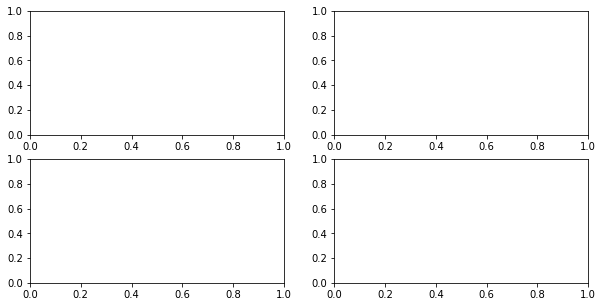

In [220]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 2, i % 2].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")
plt.show()

In [149]:
class CTVLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn =keras.backend.ctc_batch_cost
        
    def call(self,y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length =tf.cast(tf.shape(y_pred)[1], dtype ='int64')
        input_length =tf.cast(tf.shape(y_true)[1], dtype ='int64')
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred
        
        

In [96]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

 

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [150]:
epochs = 10
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Users/user/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/user/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "/Users/user/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/user/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/user/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
      ret = callback()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
      self.run()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 225, in wrapper
      runner = Runner(result, future, yielded)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 714, in __init__
      self.run()
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell
      result = self._run_cell(
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2923, in _run_cell
      return runner(coro)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-97-f8266b238eb3>", line 9, in <module>
      history = model.fit(
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/Users/user/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [7], [batch]: [6]
	 [[{{node IteratorGetNext}}]] [Op:__inference_train_function_31462]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

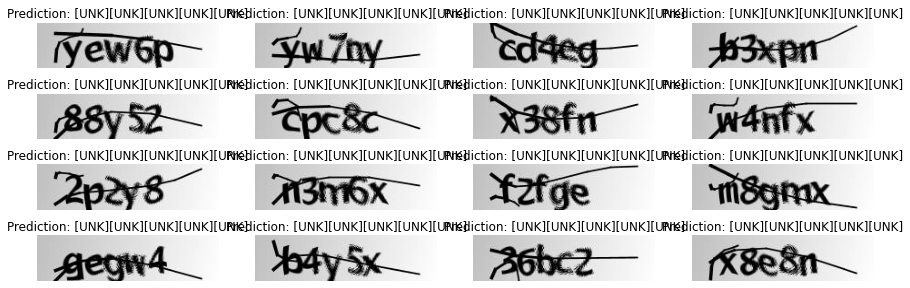

In [99]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()